No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 1 MSE: 0.9448


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 2 MSE: 1.4770


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 3 MSE: 0.8385


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 4 MSE: 1.0255


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 5 MSE: 0.9984

Cross-validation Results:
MSE scores: [0.9448306906062534, 1.476951950797437, 0.8385253681436001, 1.0254996619421142, 0.9983605104869868]
Average MSE: 1.0568 ± 0.2196

Final (in-sample) MSE: 0.086242


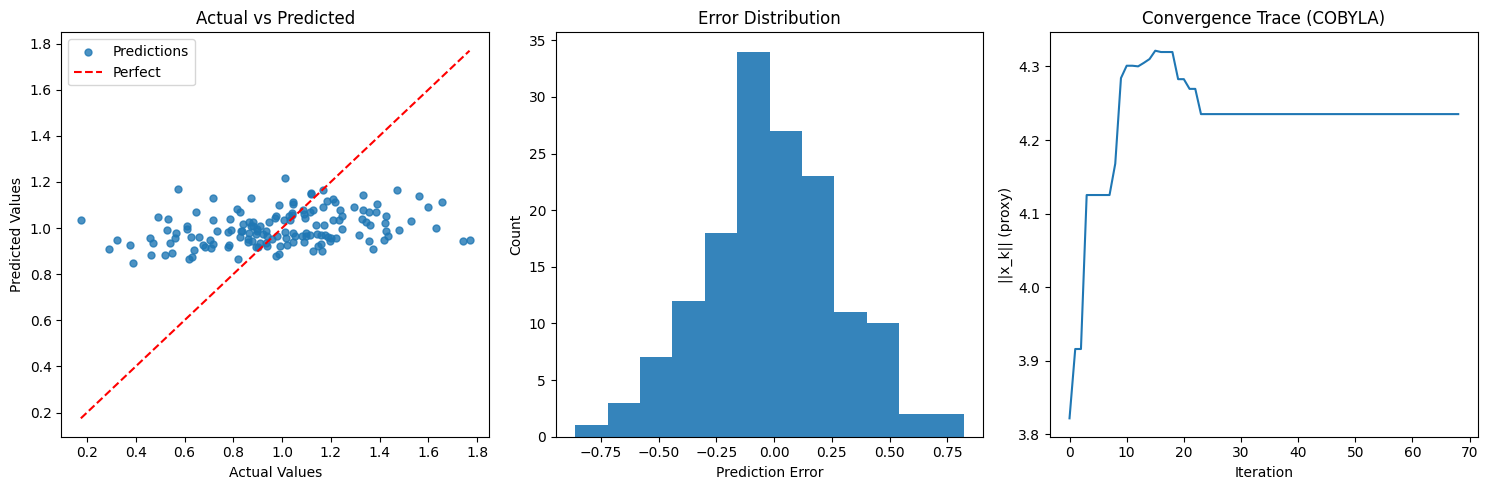

In [1]:
import numpy as np
# from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from feature_map_variations import ZZFeatureMap, ZZFeatureMapRZZ, ZZFeatureMapPoly
from ansatz_variations import RealAmplitudes, RealAmplitudesAlternating, RealAmplitudesCZ
# from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, ESCH, ISRES, DIRECT_L_RAND, CRS, ADAM, CG, POWELL
from qiskit_machine_learning.algorithms.regressors import VQR
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.connectors import TorchConnector


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# # Used in ZZFeatureMap and RealAmplitudes 
# num_reps = 3

FeatureMap = ZZFeatureMap
# FeatureMap = ZZFeatureMapRZZ
# FeatureMap = ZZFeatureMapPoly


Ansatz = RealAmplitudes
# Ansatz = RealAmplitudesAlternating
# Ansatz = RealAmplitudesCZ



# -----------------------------
# Data
# -----------------------------
def generate_data(n_samples=100):
    X = np.random.uniform(0, 1, (n_samples, 4))
    y = 0.5 * X.sum(axis=1) + 0.1 * np.random.randn(n_samples)  # (n,)
    return X, y

# -----------------------------
# Circuits (start shallow to debug)
# -----------------------------
def create_feature_map(n_qubits, num_reps):
    # return ZZFeatureMap(feature_dimension=n_qubits, reps=num_reps)
    return FeatureMap(feature_dimension=n_qubits, reps=num_reps)

def create_ansatz(n_qubits, num_reps, entanglement='linear'):
    # return RealAmplitudes(n_qubits, reps=num_reps, entanglement='linear')
    return Ansatz(n_qubits, reps=num_reps, entanglement='linear')

# -----------------------------
# Callbacks (separate for SPSA vs SciPy)
# -----------------------------
def spsa_callback(nfev, params, value, stepsize, accepted):
    if not hasattr(spsa_callback, "history"):
        spsa_callback.history = []
    spsa_callback.history.append(float(value))
    return False

def scipy_callback(xk):
    if not hasattr(scipy_callback, "history"):
        scipy_callback.history = []
    scipy_callback.history.append(np.linalg.norm(xk))
    return False

# -----------------------------
# Model factory
# -----------------------------
def setup_quantum_regression(feature_map, ansatz, which="COBYLA"):
    if which == "SPSA":
        optimizer = SPSA(maxiter=500, learning_rate=0.01, perturbation=0.1,
                         callback=spsa_callback)
    elif which == "L_BFGS_B":
        optimizer = L_BFGS_B(maxfun=300, callback=scipy_callback)
    elif which == "ESCH":
        optimizer = ESCH()  
    elif which == "ISRES":
        optimizer = ISRES()  
    elif which == "DIRECT_LRAND":
        optimizer = DIRECT_L_RAND()  
    elif which == "CRS":
        optimizer = CRS() 
    elif which == "ADAM":
        optimizer = ADAM()   
    elif which == "CG":
        optimizer = CG()    
    elif which == "POWELL":
        optimizer = POWELL(callback=scipy_callback)                           
    else:  # COBYLA
        optimizer = COBYLA(maxiter=1000, callback=scipy_callback)

    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        estimator=Estimator(),  # noiseless statevector
    )
    return vqr

# -----------------------------
# Training / Evaluation
# -----------------------------
def main(opt, num_qubits=4, num_splits=5, num_reps = 3, random_state = 42):
    np.random.seed(7)

    # data
    X, y = generate_data(n_samples=150)  # a bit more data helps
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    Xn = X_scaler.fit_transform(X)
    yn = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()  # flatten to (n,)

    # choose optimizer: "COBYLA", "L_BFGS_B", "SPSA", "ESCH"
    # WHICH_OPT = "COBYLA"
    WHICH_OPT = opt

    # CV
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=random_state)
    mses = []

    for fold, (tr, te) in enumerate(kf.split(Xn), 1):
        # reset histories
        if WHICH_OPT == "SPSA":
            spsa_callback.history = []
        else:
            scipy_callback.history = []

        n_qubits = num_qubits
        fm = create_feature_map(n_qubits, num_reps)
        ansatz = create_ansatz(n_qubits, num_reps)
        vqr = setup_quantum_regression(fm, ansatz, which=WHICH_OPT)

        vqr.fit(Xn[tr], yn[tr])
        yhat = vqr.predict(Xn[te])               # shape (m,)
        mse = np.mean((yn[te] - yhat) ** 2)
        mses.append(mse)
        print(f"Fold {fold} MSE: {mse:.4f}")

    print("\nCross-validation Results:")
    print("MSE scores:", [float(m) for m in mses])
    print(f"Average MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}")

    # Final fit on all data
    if WHICH_OPT == "SPSA":
        spsa_callback.history = []
    else:
        scipy_callback.history = []

    fm = create_feature_map(num_qubits, num_reps)
    ansatz = create_ansatz(num_qubits, num_reps)
    vqr = setup_quantum_regression(fm, ansatz, which=WHICH_OPT)
    vqr.fit(Xn, yn)
    yhat_n = vqr.predict(Xn)
    yhat = y_scaler.inverse_transform(yhat_n.reshape(-1, 1)).ravel()
    final_mse = np.mean((y - yhat) ** 2)
    print(f"\nFinal (in-sample) MSE: {final_mse:.6f}")

    # -----------------------------
    # Plots
    # -----------------------------
    plt.figure(figsize=(15, 5))

    # 1) actual vs predicted (on full data fit)
    plt.subplot(1, 3, 1)
    plt.scatter(y, yhat, s=25, alpha=0.8, label="Predictions")
    lo, hi = y.min(), y.max()
    plt.plot([lo, hi], [lo, hi], "r--", label="Perfect")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()

    # 2) error hist
    plt.subplot(1, 3, 2)
    plt.hist(y - yhat, bins=12, alpha=0.9)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Error Distribution")

    # 3) “training” trace
    plt.subplot(1, 3, 3)
    if WHICH_OPT == "SPSA":
        hist = getattr(spsa_callback, "history", [])
        plt.plot(hist)
        plt.ylabel("Objective (SPSA)")
    else:
        hist = getattr(scipy_callback, "history", [])
        plt.plot(hist)
        plt.ylabel("||x_k|| (proxy)")
    plt.xlabel("Iteration")
    plt.title(f"Convergence Trace ({WHICH_OPT})")

    plt.tight_layout()
    plt.show()


"""Optimizers that works with call backs for plotting loss history:
   1. COBYLA
   2. L_BFGS_B
   3. SPSA
   4. SLSQP
   
Optimizers that does NOT work with call backs for plotting loss history:
   1. ESCH
   2. ISRES
   3. DIRECT_LRAND
   4. CRS
   5. ADAM
   
"""

if __name__ == "__main__":
    main(opt="COBYLA", num_qubits=4, num_splits=5, num_reps = 3, random_state = 42)
